# 利用數值微分方法，找到函數的微分 (偏微分) 解
## df(x) / dx = lim h-> 0 (f(x+h) - f(x)) / h

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

!pip install -q tqdm 

## 一個簡單的方程式
$ f(x) = 0.01x^2 + 0.1x $

In [0]:
# Define a target function
def my_function(x):
    # y = 0.01x^2 + 0.1x
    return 0.01*x**2 + 0.1*x

In [12]:
def numerical_diff(f, x):
    h = 1e-4
    return ( f(x+h) - f(x-h) ) / (2 * h)

print(numerical_diff(my_function, 5))
print(numerical_diff(my_function, 10))

0.1999999999990898
0.2999999999986347


# 梯度
### To visualize the curve: https://goo.gl/iXTXGc
$ x0^2 + x1^2 $

In [13]:
#@title  { run: "auto", vertical-output: true }
def partial_derivative(x):
    return x[0]**2 + x[1]**2

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite']) # a multi-dimensional iterator (to iterate over an array)
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = float(tmp_val) - h 
        fxh2 = f(x) # f(x-h)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # assign it back, so as to change next value
        it.iternext()   
        
    return grad

print(numerical_gradient(partial_derivative, np.array([3.0, 4.0])))
print(numerical_gradient(partial_derivative, np.array([3.0, 2.0])))
print(numerical_gradient(partial_derivative, np.array([0.0, 0.0])))

[6. 8.]
[6. 4.]
[0. 0.]


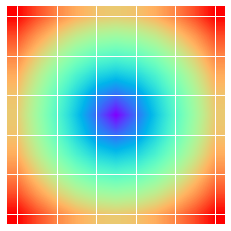

In [14]:
#@title 把每一個格子點的微分結果 (梯度) 用迴圈方式算出 { run: "auto", vertical-output: true }
example_grad = np.zeros((11,11))
for i in np.arange(-5,6):
    for j in np.arange(-5,6):
        x_vec, y_vec = numerical_gradient(partial_derivative, np.array([np.float32(i), np.float32(j)]))
        net_vec = np.sqrt(x_vec**2 + y_vec**2)
        example_grad[i+5,j+5] = net_vec
plt.imshow(example_grad, cmap = 'rainbow', interpolation='bilinear')
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
plt.show()

$$ x^2 + y^2 $$
$$ x^2 - y^2 $$
![Image of gradient](https://mse.redwoods.edu/darnold/math50c/matlab/gradient/figure3.png)

# Define two layers network

In [0]:
# define activation: sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# define activation: softmax
def softmax(x):
    if x.ndim == 2:
        x = x.T # Transpose it
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    return np.exp(x) / np.sum(np.exp(x))

# define cross_entropy
def cross_entropy(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [0]:
class Two_layerNet:
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size, 
                 weight_init_std = 0.01):
        self.params = {}
        self.params['w1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['w2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        # forward
        w1, w2 = self.params['w1'], self.params['w2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, w1) + b1
        z1 = sigmoid(a1)
        
        a2 = np.dot(z1, w2) + b2
        y = softmax(a2)
        return y
        
    def loss(self, x, y_true):
        y_pred = self.predict(x)
        return cross_entropy(y_pred, y_true)
    
    def compute_acc(self, x, y_true):
        y_pred = self.predict(x)
        # take argmax
        y_pred = y_pred.argmax(axis = 1) 
        y_true = y_true.argmax(axis = 1)
        
        acc = np.sum(y_pred == y_true) / len(y_true)
        return acc
    
    def numerical_gradient(self, x, y_true):
        loss_W = lambda w: self.loss(x, y_true)
        #print(loss_W)
        
        grads = {}
        grads['w1'] = numerical_gradient(loss_W, self.params['w1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['w2'] = numerical_gradient(loss_W, self.params['w2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads


  5%|▍         | 234/5001 [03:21<1:08:32,  1.16it/s]

100%|██████████| 5001/5001 [1:13:10<00:00,  1.14it/s]


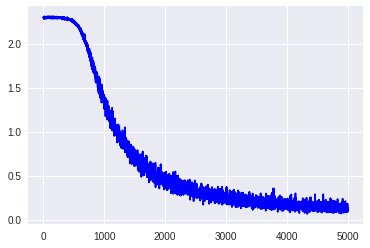

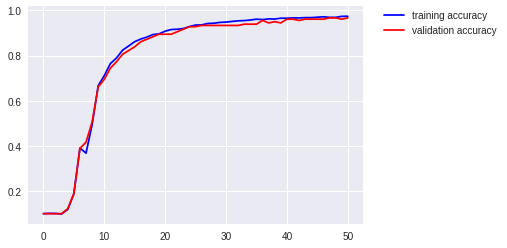

In [26]:
#@title 使用 Tensorflow MNIST Dataset? { run: "auto", vertical-output: true }
large_mnist = False #@param ["False", "True"] {type:"raw"}

if large_mnist:
  # Load data from tensorflow MNIST dataset, which image size is 28 x 28 
  from tensorflow.examples.tutorials.mnist import input_data
  mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
  x_ = mnist.train.images
  y_ = mnist.train.labels
else:
  # Load data from sklearn MNIST (digit) dataset, which image size is 8 x 8
  from sklearn.datasets import load_digits
  digits = load_digits()
  x_, y_single = digits.data, digits.target

  # do some data preprocessing
  y_ = np.zeros((len(y_single), 10))
  y_[np.arange(len(y_)), y_single] = 1


from sklearn.model_selection import train_test_split
from tqdm import tqdm

x_ = x_ / x_.max() # normailze it to 0 - 1

# do train_test split
x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size = 0.1, stratify = y_)

# define training settings ------------
train_loss_list = []
train_acc_list = []
test_acc_list = []

iters_num = 5001
train_size = x_train.shape[0] # numbers of training samples
bz = 100 # batch size
lr = 0.1 # learning rate

network = Two_layerNet(input_size=x_.shape[-1], # 784 for MNIST, 64 for digit
                       hidden_size=25, 
                       output_size=10)

for i in tqdm(range(iters_num)):
    batch_mask = np.random.choice(train_size, bz)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.numerical_gradient(x_batch, y_batch) # already contain a feed-forward processing in this step
    
    for key in ("w1", "b1", "w2", "b2"):
        network.params[key] -= lr * grad[key]
        
    this_loss = network.loss(x_batch, y_batch)
    train_loss_list.append(this_loss)
    
    if i % 100 == 0:
        # compute accuracy for every 50 updates
        train_acc = network.compute_acc(x_train, y_train)
        test_acc = network.compute_acc(x_test, y_test)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        #print("Train accuarcy, Test accuracy | " + str(train_acc) + ", " + str(test_acc))
        
plt.plot(np.arange(len(train_loss_list)), train_loss_list, 'b-')
plt.show()

plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'b-', label = 'training accuracy')
plt.plot(np.arange(len(test_acc_list)), test_acc_list, 'r-', label = 'validation accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()